# Load in packages and define functions

### package installation

In [1]:
import matplotlib.pyplot as plt
import xarray
import numpy as np
import datetime
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from glob import glob
from netCDF4 import Dataset
from scipy.stats import beta, pearsonr
from statsmodels.tsa import stattools
import matplotlib.patches as mpatches

from tqdm import tqdm

### common functions

In [2]:
# Implementing decimal year fxn found here: https://stackoverflow.com/questions/6451655/how-to-convert-python-datetime-dates-to-decimal-float-years
# Input: array of np.datetime64 objects
# Output: same array converted into decimal year format, to be used for fitting models to a time series
def to_decimal_year(time):
    dt = pd.to_datetime(time) # converts np.datetime64 into datetime object
    dec_year = []
    for i in range(len(dt)):
        start = datetime.date(dt[i].year,1,1).toordinal()
        year_length = datetime.date(dt[i].year+1, 1, 1).toordinal() - start
        dec_year.append(dt[i].year + (float(dt[i].toordinal() - start) / year_length)) # calculates how much time has passed in the year, divides by year length, then adds to start year
    return np.array(dec_year)

In [3]:
# Remove trend from data by fitting a series of harmonics
# Input: array of times in np.datetime64 format, data array, number of harmonics (int), whether or not to remove trend (Boolean)
# Output: data array with mean, trend and/or seasonal cycle removed if specified
def detrend_data(t,data,num_harmonics=0, remove_trend=False):
    dyr = to_decimal_year(t) # convert from date-time to decimal year
    
    model = [np.ones(len(dyr)), dyr - np.mean(dyr)]
    for i in range(num_harmonics): # adding harmonics to model
        omega = 2*(i+1)*np.pi
        model.append(np.sin(omega*dyr))
        model.append(np.cos(omega*dyr))
    pmodel = np.linalg.pinv(np.array(model))
    
    # calculate coefficients / residuals (as specified by input)
    coefs = np.matmul(data, pmodel)
    mean = coefs[0]
    trend = coefs[1]*(dyr - np.mean(dyr))
    res_coefs = coefs[2:]
    
    seasons_model = [] # initialize model to be populated with code below
    
    if remove_trend == True: # case for removing both trend and seasonal cycle
        detrend_data = data-mean-trend
        for j in range(0,len(res_coefs),2):
            omega = (j+2)*np.pi
            detrend_data = detrend_data-(res_coefs[j]*np.sin(omega*dyr))-(res_coefs[j+1]*np.cos(omega*dyr)) 
            seasons_model.append(res_coefs[j]*np.sin(omega*dyr))
            seasons_model.append(res_coefs[j+1]*np.cos(omega*dyr))
            
    else: # case for leaving trend, removing seasonal cycle
        detrend_data = data-mean
        for j in range(0,len(res_coefs),2):
            omega = (j+2)*np.pi
            detrend_data = detrend_data-(res_coefs[j]*np.sin(omega*dyr))-(res_coefs[j+1]*np.cos(omega*dyr))
            seasons_model.append(res_coefs[j]*np.sin(omega*dyr))
            seasons_model.append(res_coefs[j+1]*np.cos(omega*dyr))
    
    seasons_model_final = np.sum(np.array(seasons_model), axis=0)
    
    results = {}
    results['data'] = detrend_data
    results['coefs'] = coefs
    results['trend'] = trend
    results['seasons_model'] = seasons_model_final
    
    return results

In [4]:
def detrend_data_from_coefs(t,data,coefs,return_seasons=False):
    dyr = to_decimal_year(t) # convert from date-time to decimal year
    mean = coefs[0]
    trend = coefs[1]*(dyr - np.mean(dyr))
    res_coefs = coefs[2:]
    
    seasons_model = [] # initialize model to be populated with code below
    
    detrend_data = data-mean-trend
    for j in range(0,len(res_coefs),2):
        omega = (j+2)*np.pi
        detrend_data = detrend_data-(res_coefs[j]*np.sin(omega*dyr))-(res_coefs[j+1]*np.cos(omega*dyr)) 
        seasons_model.append(res_coefs[j]*np.sin(omega*dyr))
        seasons_model.append(res_coefs[j+1]*np.cos(omega*dyr))
        
    if return_seasons:
        seasons_model_final = np.sum(np.array(seasons_model), axis=0)
        return detrend_data,seasons_model_final
    return detrend_data

# Extract data

In [5]:
files = np.sort(glob('/Users/erickson/Documents/Data/RFROM/*.nc'))
data = xarray.open_mfdataset(files)

In [6]:
latitude_locations = [43,0,-35]
longitude_locations = [-135,-160,155]
latitude_inds = np.array([np.argmin(np.abs(l-data.variables['latitude'].values)) for l in latitude_locations])
longitude_inds = np.array([np.argmin(np.abs(np.mod(l,360)-data.variables['longitude'].values)) for l in longitude_locations])

In [7]:
supp_latitude_locations =     [-18, 8, 40,-40,-45,  15]
supp_longitude_locations = [-110,-115,-60,-50, 60,-110]
supp_latitude_inds = np.array([np.argmin(np.abs(l-data.variables['latitude'].values)) for l in supp_latitude_locations])
supp_longitude_inds = np.array([np.argmin(np.abs(np.mod(l,360)-data.variables['longitude'].values)) for l in supp_longitude_locations])

In [8]:
yeartime = to_decimal_year(data['time'].values)
pressure = data['mean_pressure'].values

# Figure 1: Time series

In [9]:
pres = [2.5,150]
presinds = [np.argmin(np.abs(data['mean_pressure'].values-p)) for p in pres]
temps = [data['ocean_temperature'][:,ind,latitude_inds[0],longitude_inds[0]].values for ind in presinds]

In [10]:
temp_detrend = [detrend_data(data['time'].values, t, num_harmonics=6, remove_trend=True) for t in temps]

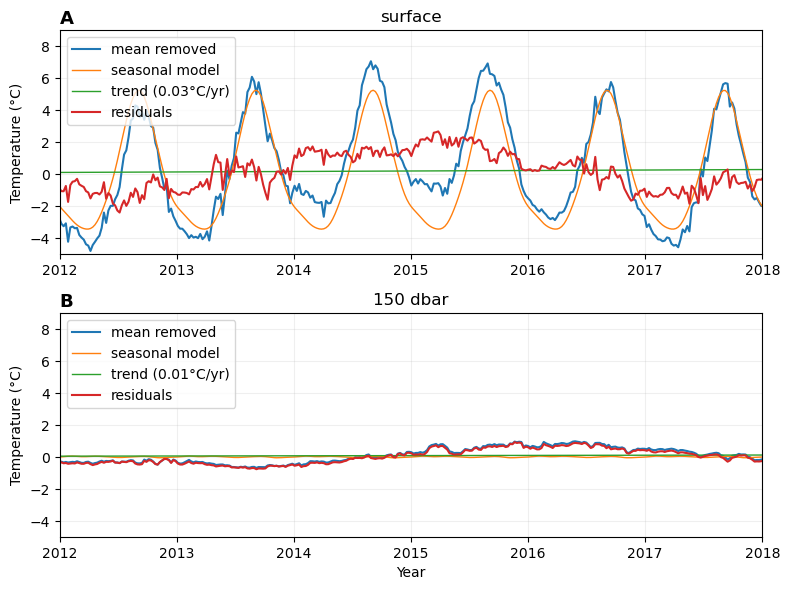

In [11]:
fig,ax = plt.subplots(2,1,figsize=(8,6))
for i in range(2):
    ax[i].plot(yeartime, temps[i]-np.mean(temps[i]),label='mean removed')
    ax[i].plot(yeartime, temp_detrend[i]['seasons_model'], label='seasonal model', lw=1) # verifying seasons model is realistic-looking
    ax[i].plot(yeartime, temp_detrend[i]['trend'], label='trend (%.02f°C/yr)'%temp_detrend[i]['coefs'][1], lw=1) # verifying trend != 0
    ax[i].plot(yeartime, temp_detrend[i]['data'], label='residuals')

for a in ax:
    a.set_ylim([-5,9])
    a.set_xlim([2012,2018])
    a.set_ylabel('Temperature (°C)')
    a.legend(loc='upper left',framealpha=0.8,ncol=1)
    a.grid(alpha=0.2)

ax[0].set_title('surface')
ax[1].set_title('%d dbar'%pres[1])
ax[1].set_xlabel('Year')
plt.tight_layout()

for a,panel in zip(ax,['A','B']):
    a.annotate(panel,(0.0,1.03),xycoords='axes fraction',fontweight='bold',fontsize=13)

plt.savefig('Figure_timeseries_final.png',dpi=300)

# Figure 1: T stdev map

In [12]:
nc = Dataset('stdev_T.nc','r')
ncvars = nc.variables
ncvars.keys()

dict_keys(['depth', 'latitude', 'longitude', 'stdev'])

In [13]:
nodata = np.isnan(ncvars['stdev'][1])

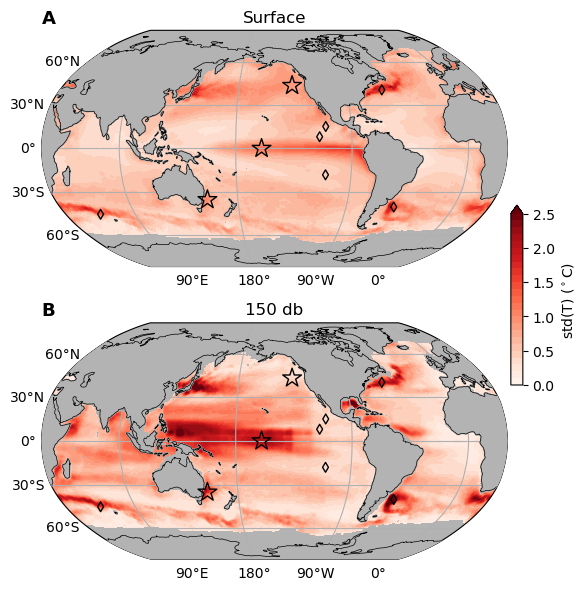

In [14]:
fig = plt.figure(figsize=(6,6))
ax = (fig.add_subplot(2, 1, 1, projection=ccrs.Robinson(210)),
      fig.add_subplot(2, 1, 2, projection=ccrs.Robinson(210)))
for a in ax:
    a.set_global()
    a.coastlines(zorder=9,lw=0.5)
    a.add_feature(cfeature.LAND, color='0.7',zorder=3)
    a.add_feature(cfeature.LAND, color='0.7',zorder=3)
    gl = a.gridlines(draw_labels=True,xlocs=np.arange(-180,180,90))
    gl.top_labels = False
    a.scatter(longitude_locations,latitude_locations,marker='*',s=200,transform=ccrs.PlateCarree(),zorder=10,facecolor='none',edgecolor='k')
    a.scatter(supp_longitude_locations,supp_latitude_locations,marker='d',s=25,transform=ccrs.PlateCarree(),zorder=10,facecolor='none',edgecolor='k')
    a.contourf(ncvars['longitude'][:],ncvars['latitude'][:],nodata,levels=[0.5,1.5],colors=['0.7','none'],transform=ccrs.PlateCarree())

    
c = ax[0].contourf(ncvars['longitude'][:],ncvars['latitude'][:],ncvars['stdev'][0],cmap=plt.cm.Reds,levels=np.arange(0,2.6,0.1),extend='max',transform=ccrs.PlateCarree())
ax[1].contourf(ncvars['longitude'][:],ncvars['latitude'][:],ncvars['stdev'][1],cmap=plt.cm.Reds,levels=np.arange(0,2.6,0.1),extend='max',transform=ccrs.PlateCarree())
ax[0].set_title('Surface')
ax[1].set_title('150 db')

plt.tight_layout()

cax = fig.add_axes([0.9,0.35,0.02,0.3])
cbar = fig.colorbar(c,cax=cax,label=r'std(T) ($^\circ$C)',ticks=np.arange(0,2.6,.5))

for a,panel in zip(ax,['A','B','C']):
    a.annotate(panel,(0.0,1.03),xycoords='axes fraction',fontweight='bold',fontsize=13)

plt.savefig('Figure_stdevT_final.png',dpi=300)

# Figure 3: temperature anomalies

In [15]:
ocean_temperatures = np.array([data['ocean_temperature'][:,:,latind,lonind].values for latind,lonind in zip(latitude_inds,longitude_inds)])

In [16]:
temp_detrend = np.empty(shape=ocean_temperatures.shape)
for i in range(len(temp_detrend)):
    print(i)
    for j in tqdm(range(len(pressure))):
        temp_detrend[i,:,j] = detrend_data(data['time'].values, ocean_temperatures[i,:,j], num_harmonics=6, remove_trend=True)['data']
    print('')

0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 32.88it/s]



1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 36.50it/s]



2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 35.89it/s]

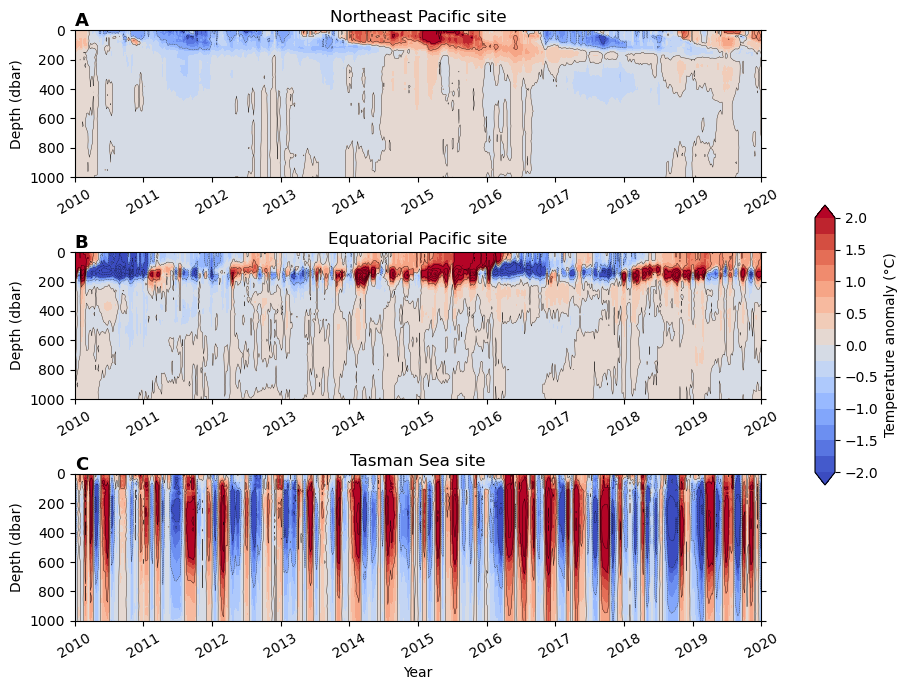

In [17]:
fig,ax = plt.subplots(3,1,figsize=(10,7))
for i in range(3):
    c = ax[i].contourf(data['time'].values,pressure,temp_detrend[i].T,cmap=plt.cm.coolwarm,levels=np.arange(-2,2.01,.25),extend='both')
    ax[i].contour(data['time'].values,pressure,temp_detrend[i].T,levels=np.arange(-10,10.1,1),colors='k',linewidths=0.25)
    ax[i].set_ylim([1000,0])
    ax[i].tick_params(axis='x', labelrotation=30)
    ax[i].set_ylabel('Depth (dbar)')
    ax[i].yaxis.set_ticks_position('both')
ax[2].set_xlabel('Year')
ax[0].set_xlim([datetime.date(2010,1,1),datetime.date(2020,1,1)])
ax[1].set_xlim([datetime.date(2010,1,1),datetime.date(2020,1,1)])
ax[2].set_xlim([datetime.date(2010,1,1),datetime.date(2020,1,1)])
ax[0].set_title('Northeast Pacific site')
ax[1].set_title('Equatorial Pacific site')
ax[2].set_title('Tasman Sea site')
plt.tight_layout(rect=(0,0,0.8,1))
cax = fig.add_axes([0.82,0.3,0.02,0.4])
plt.colorbar(c,cax=cax,label='Temperature anomaly (°C)')
for a,panel in zip(ax,['A','B','C']):
    a.annotate(panel,(0.0,1.03),xycoords='axes fraction',fontweight='bold',fontsize=13)

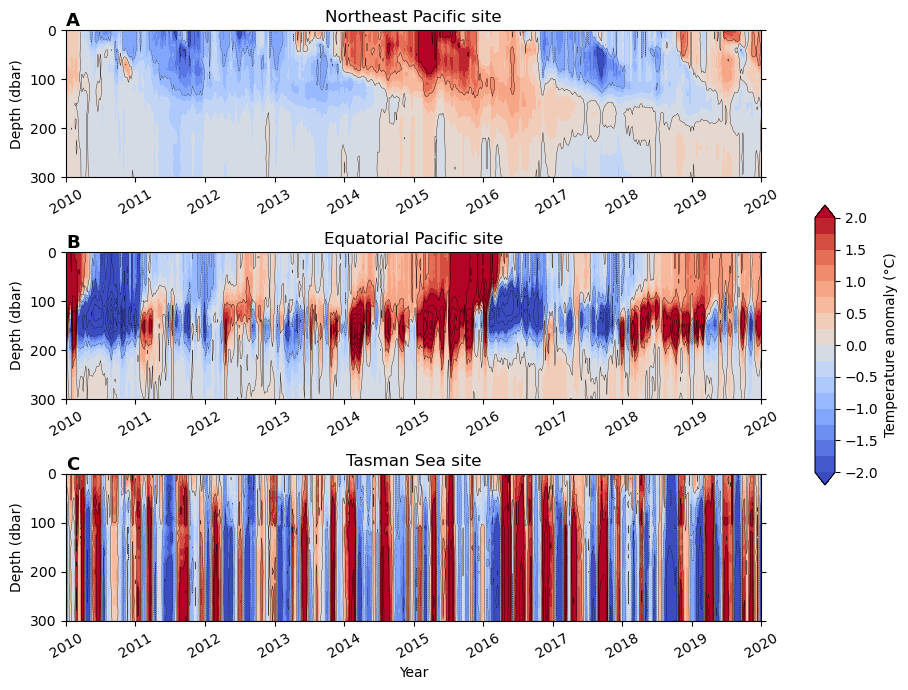

In [18]:
fig,ax = plt.subplots(3,1,figsize=(10,7))
for i in range(3):
    c = ax[i].contourf(data['time'].values,pressure,temp_detrend[i].T,cmap=plt.cm.coolwarm,levels=np.arange(-2,2.01,.25),extend='both')
    ax[i].contour(data['time'].values,pressure,temp_detrend[i].T,levels=np.arange(-10,10.1,1),colors='k',linewidths=0.25)
    ax[i].set_ylim([300,0])
    ax[i].tick_params(axis='x', labelrotation=30)
    ax[i].set_ylabel('Depth (dbar)')
    ax[i].yaxis.set_ticks_position('both')
ax[2].set_xlabel('Year')
ax[0].set_xlim([datetime.date(2010,1,1),datetime.date(2020,1,1)])
ax[1].set_xlim([datetime.date(2010,1,1),datetime.date(2020,1,1)])
ax[2].set_xlim([datetime.date(2010,1,1),datetime.date(2020,1,1)])
ax[0].set_title('Northeast Pacific site')
ax[1].set_title('Equatorial Pacific site')
ax[2].set_title('Tasman Sea site')
plt.tight_layout(rect=(0,0,0.8,1))
cax = fig.add_axes([0.82,0.3,0.02,0.4])
plt.colorbar(c,cax=cax,label='Temperature anomaly (°C)')
for a,panel in zip(ax,['A','B','C']):
    a.annotate(panel,(0.0,1.03),xycoords='axes fraction',fontweight='bold',fontsize=13)

plt.savefig('Figure_anomalies_final.png',dpi=300)

# Figure 4: lagged correlations

In [86]:
def lag_corr(array1,array2,lag,return_n = False,nlags=200):
    T1 = 2*np.max(np.cumsum(stattools.acf(array1,nlags=nlags)))
    T2 = 2*np.max(np.cumsum(stattools.acf(array2,nlags=nlags)))
    if lag>0:
        r = pearsonr(array2[lag:-1],array1[:-1-lag])[0]
    elif lag<0:
        l = int(-1.*lag)
        r = pearsonr(array1[l:-1],array2[:-1-l])[0]
    else:
        r = pearsonr(array1,array2)[0]
    l = len(array1)-np.abs(lag)
    n = (l/T1 + l/T2)/2 - 8
    dist = beta(n/2-1,n/2-1,loc=-1,scale=2)
    p = 2*dist.cdf(-abs(r))
    if return_n:
        return r,p,n
    else:
        return r,p

In [87]:
lags = np.arange(-52*1,int(np.ceil(52*2.5))+1)
lagged_corr = np.zeros(shape=(3,len(pressure),len(lags)))*np.nan
lagged_p = np.zeros(shape=(3,len(pressure),len(lags)))*np.nan
lagged_n = np.zeros(shape=(3,len(pressure),len(lags)))*np.nan

for i in range(3):
    print(i,end='')
    for j in tqdm(range(len(pressure))):
        for k in range(len(lags)):
            lagged_corr[i,j,k],lagged_p[i,j,k],lagged_n[i,j,k] = lag_corr(temp_detrend[i,:,0],temp_detrend[i,:,j],lags[k],return_n = True)
    print('')

0

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:11<00:00,  3.77it/s]



1

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:12<00:00,  3.49it/s]



2

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:11<00:00,  3.77it/s]

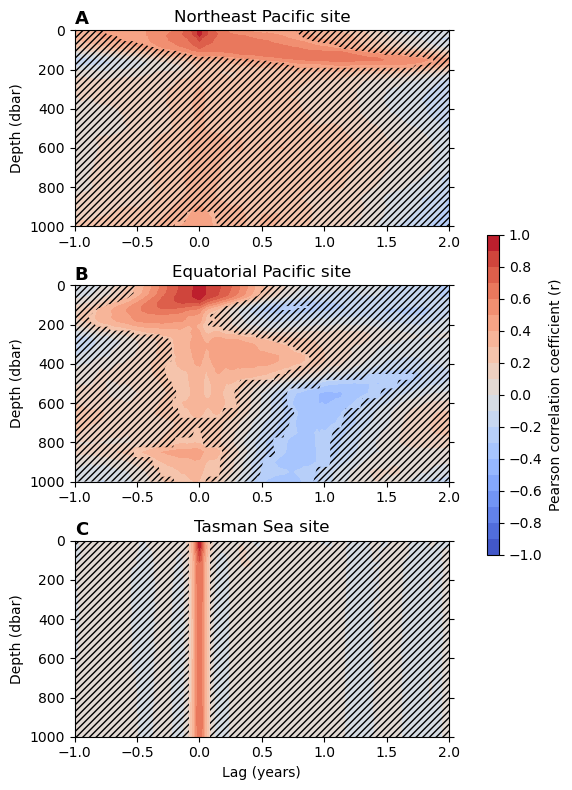

In [88]:
fig,ax = plt.subplots(3,1,figsize=(6,8))
for i in range(3):
    c = ax[i].contourf(lags/52,pressure,lagged_corr[i],cmap=plt.cm.coolwarm,levels=np.arange(-1,1.01,.1))
    ax[i].contourf(lags/52,pressure,lagged_p[i]>0.1,levels=[0.5,1.5],hatches=['/////'],colors=['none'])
    ax[i].set_ylim([1000,0])
    ax[i].set_xlim([-1,2])
    ax[i].set_ylabel('Depth (dbar)')
    ax[i].yaxis.set_ticks_position('both')
ax[2].set_xlabel('Lag (years)')
ax[0].set_title('Northeast Pacific site')
ax[1].set_title('Equatorial Pacific site')
ax[2].set_title('Tasman Sea site')
plt.tight_layout(rect=(0,0,0.8,1))
cax = fig.add_axes([0.82,0.3,0.02,0.4])
plt.colorbar(c,cax=cax,label='Pearson correlation coefficient (r)',ticks=np.arange(-1,1.01,.2))
for a,panel in zip(ax,['A','B','C']):
    a.annotate(panel,(0.0,1.03),xycoords='axes fraction',fontweight='bold',fontsize=13)

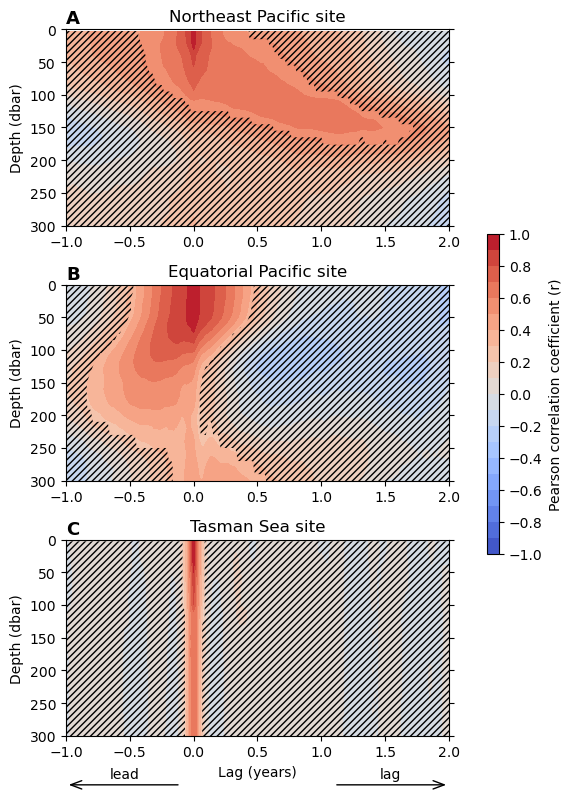

In [89]:
fig,ax = plt.subplots(3,1,figsize=(6,8))
for i in range(3):
    c = ax[i].contourf(lags/52,pressure,lagged_corr[i],cmap=plt.cm.coolwarm,levels=np.arange(-1,1.01,.1))
    ax[i].contourf(lags/52,pressure,lagged_p[i]>0.05,levels=[0.5,1.5],hatches=['/////'],colors=['none'])
    ax[i].set_ylim([300,0])
    ax[i].set_xlim([-1,2])
    ax[i].set_ylabel('Depth (dbar)')
    ax[i].yaxis.set_ticks_position('both')
ax[2].set_xlabel('Lag (years)')
ax[0].set_title('Northeast Pacific site')
ax[1].set_title('Equatorial Pacific site')
ax[2].set_title('Tasman Sea site')
plt.tight_layout(rect=(0,0,0.8,1))
cax = fig.add_axes([0.82,0.3,0.02,0.4])
plt.colorbar(c,cax=cax,label='Pearson correlation coefficient (r)',ticks=np.arange(-1,1.01,.2))
for a,panel in zip(ax,['A','B','C']):
    a.annotate(panel,(0.0,1.03),xycoords='axes fraction',fontweight='bold',fontsize=13)
    
arr1 = mpatches.FancyArrowPatch((.3*3-1, 1.25*300), (0*3-1, 1.25*300),
                               arrowstyle='->,head_width=.15', mutation_scale=20,clip_on=False)
arr2 = mpatches.FancyArrowPatch((.7*3-1, 1.25*300), (1*3-1, 1.25*300),
                               arrowstyle='->,head_width=.15', mutation_scale=20,clip_on=False)
ax[2].add_patch(arr1)
ax[2].add_patch(arr2)
ax[2].annotate("lead", (.5, 1), xycoords=arr1, ha='center', va='bottom')
ax[2].annotate("lag", (.5, 1), xycoords=arr2, ha='center', va='bottom')

plt.savefig('Figure_lagged_correlation_final.png',dpi=300)

# Figure 5: lagged correlation maps

In [23]:
nc = Dataset('lagged_correlation_analysis_150m_final.nc','r')
ncvars = nc.variables
print(ncvars.keys())
lags = ncvars['lag'][:]

dict_keys(['lag', 'lat', 'lon', 'lagged_corr', 'lagged_p', 'lagged_n'])


In [24]:
max_correlation_arg = np.ones(shape=(180,360)).astype('int')
for i in tqdm(range(180)):
    for j in range(360):
        if np.any(ncvars['lagged_p'][:,i,j]<0.05):
            valid_inds = np.arange(len(lags))[ncvars['lagged_p'][:,i,j]<0.05]
            max_correlation_arg[i,j] = valid_inds[np.argmax(np.abs(ncvars['lagged_corr'][:,i,j][valid_inds]))]
        else:
            max_correlation_arg[i,j] = 0
            

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [06:50<00:00,  2.28s/it]


In [25]:
shape = max_correlation_arg.shape
max_correlation_lag = np.empty(shape=shape)
max_correlation = np.empty(shape=shape)
max_correlation_p = np.empty(shape=shape)
for i in tqdm(range(shape[0])):
    for j in range(shape[1]):
        if max_correlation_arg[i,j]==0:
            max_correlation_lag[i,j] = np.nan; max_correlation[i,j] = np.nan; max_correlation_p[i,j] = np.nan;
        else:
            max_correlation_lag[i,j] = lags[max_correlation_arg[i,j]]
            max_correlation[i,j] = ncvars['lagged_corr'][max_correlation_arg[i,j],i,j]
            max_correlation_p[i,j] = ncvars['lagged_p'][max_correlation_arg[i,j],i,j]

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:09<00:00, 19.06it/s]


In [26]:
shape = max_correlation_arg.shape
max_significant_lag = np.empty(shape=shape)
for i in tqdm(range(shape[0])):
    for j in range(shape[1]):
        if max_correlation_arg[i,j]==0:
            max_significant_lag[i,j] = np.nan;
        else:
            inds = np.where(ncvars['lagged_p'][:,i,j]<0.05)[0]
            center_ind = np.where(lags==0)[0][0]
            closest_to_center_ind = inds[np.argmin(np.abs(inds-center_ind))]
            gap_inds = np.where(np.diff(inds)>1)[0]
            lower_ind = gap_inds[np.where(inds[gap_inds]<closest_to_center_ind)[0][-1]] if np.any(inds[gap_inds]<closest_to_center_ind) else -1
            higher_ind = gap_inds[np.where(inds[gap_inds]>closest_to_center_ind)[0][0]] if np.any(inds[gap_inds]>closest_to_center_ind) else len(inds)-1
            inds_to_use = inds[lower_ind+1:higher_ind+1]
            max_significant_lag[i,j] = lags[inds_to_use][np.argmax(np.abs(lags[inds_to_use]))]

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [01:22<00:00,  2.18it/s]


In [112]:
max_correlation_lag_visual = np.nan*np.empty(shape=shape)
bounds = [-3*52,-2*52,-1*52,-26,-12,-4,-1,1,4,12,26,52,2*52,3*52]
for i in range(len(bounds)-1):
    iii = (max_correlation_lag>bounds[i]) & (max_correlation_lag<=bounds[i+1])
    max_correlation_lag_visual[iii] = i+.5

max_significant_lag_visual = np.nan*np.empty(shape=shape)
bounds = [-3*52,-2*52,-1*52,-26,-12,-4,-1,1,4,12,26,52,2*52,3*52]
for i in range(len(bounds)-1):
    iii = (max_significant_lag>bounds[i]) & (max_significant_lag<=bounds[i+1])
    max_significant_lag_visual[iii] = i+.5

no_sigvals = np.isnan(max_correlation) & ~nodata

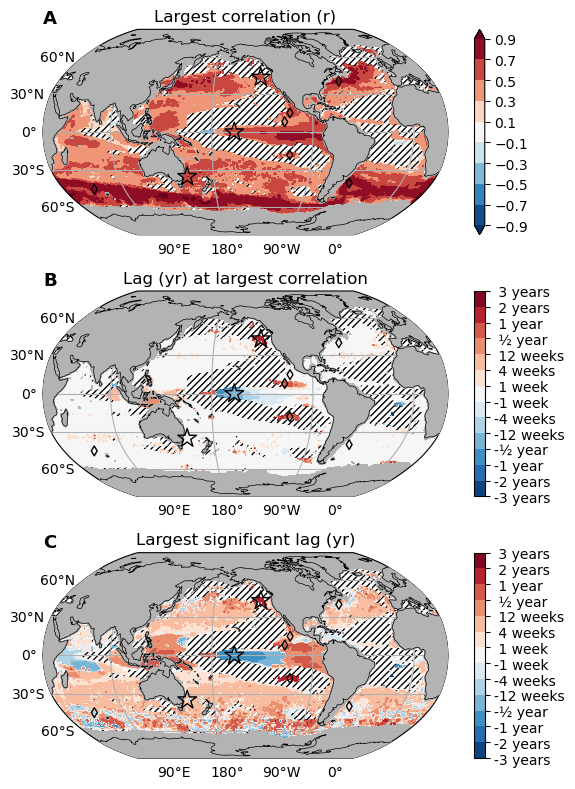

In [113]:
fig = plt.figure(figsize=(6,8))
ax = (fig.add_subplot(3, 1, 1, projection=ccrs.Robinson(210)),
      fig.add_subplot(3, 1, 2, projection=ccrs.Robinson(210)),
      fig.add_subplot(3, 1, 3, projection=ccrs.Robinson(209.9))) # a weird bug means this doesn't work at 210°...
for a in ax:
    a.set_global()
    a.coastlines(zorder=9,lw=0.5)
    a.add_feature(cfeature.LAND, color='0.7',zorder=3)
    a.add_feature(cfeature.LAND, color='0.7',zorder=3)
    gl = a.gridlines(draw_labels=True,xlocs=np.arange(-180,180,90))
    gl.top_labels = False
    a.scatter(longitude_locations,latitude_locations,marker='*',s=200,transform=ccrs.PlateCarree(),zorder=10,facecolor='none',edgecolor='k')
    a.scatter(supp_longitude_locations,supp_latitude_locations,marker='d',s=25,transform=ccrs.PlateCarree(),zorder=10,facecolor='none',edgecolor='k')


c1 = ax[0].contourf(ncvars['lon'][:],ncvars['lat'][:],max_correlation,cmap=plt.cm.RdBu_r,levels=np.arange(-.9,.91,0.2),extend='both',transform=ccrs.PlateCarree())
c2 = ax[1].contourf(ncvars['lon'][:],ncvars['lat'][:],max_correlation_lag_visual,cmap=plt.cm.RdBu_r,levels=np.arange(len(bounds)),transform=ccrs.PlateCarree())
c3 = ax[2].contourf(ncvars['lon'][:],ncvars['lat'][:],max_significant_lag_visual,cmap=plt.cm.RdBu_r,levels=np.arange(len(bounds)),transform=ccrs.PlateCarree())
for a in ax:
    a.contourf(ncvars['lon'][:],ncvars['lat'][:],no_sigvals,levels=[0.5,1.5],hatches=['/////'],colors=['none'],transform=ccrs.PlateCarree())
    a.contourf(ncvars['lon'][:],ncvars['lat'][:],nodata,levels=[0.5,1.5],colors=['0.7','none'],transform=ccrs.PlateCarree())
ax[0].set_title('Largest correlation (r)')
ax[1].set_title('Lag (yr) at largest correlation')
ax[2].set_title('Largest significant lag (yr)')

cbar1 = plt.colorbar(c1,ax=ax[0],ticks=np.arange(-.9,1.,.2))
cbar2 = plt.colorbar(c2,ax=ax[1],ticks=np.arange(len(bounds)))
cbar3 = plt.colorbar(c3,ax=ax[2],ticks=np.arange(len(bounds)))
cbar2.ax.set_yticklabels(['-3 years','-2 years','-1 year','-½ year','-12 weeks','-4 weeks','-1 week',' 1 week',' 4 weeks',' 12 weeks',' ½ year',' 1 year',' 2 years',' 3 years']);cbar3.ax.set_yticklabels(['-3 years','-2 years','-1 year','-1/2 year','-1/4 year','-4 weeks','-1 week','1 week','4 weeks','1/4 year','1/2 year','1 year','2 years','3 years']);
cbar3.ax.set_yticklabels(['-3 years','-2 years','-1 year','-½ year','-12 weeks','-4 weeks','-1 week',' 1 week',' 4 weeks',' 12 weeks',' ½ year',' 1 year',' 2 years',' 3 years']);

plt.tight_layout()

for a,panel in zip(ax,['A','B','C']):
    a.annotate(panel,(0.0,1.03),xycoords='axes fraction',fontweight='bold',fontsize=13)

plt.savefig('Figure_correlation_maps_final.png',dpi=300);

## Make map of different types of signatures

In [105]:
def make_signatures(maxcorr,maxcorrlag,maxsiglag):
    if (maxcorrlag>26) & (maxcorr>0):# & (maxsiglag>26):
        return 1
    elif (maxcorr>0) & (maxcorrlag<-4):# & (maxsiglag<-4):
        return 2
    elif (np.abs(maxcorrlag)<=1) & (np.abs(maxsiglag)<=12) & (maxcorr>0.5):
        return 3
    else:
        return 4

In [106]:
subsurface_anomaly_signature = np.empty(shape=shape)
for i in range(shape[0]):
    for j in range(shape[1]):
        if np.isnan(max_correlation[i,j]):
            subsurface_anomaly_signature[i,j] = np.nan
        else:
            subsurface_anomaly_signature[i,j] = make_signatures(max_correlation[i,j],max_correlation_lag[i,j],max_significant_lag[i,j])

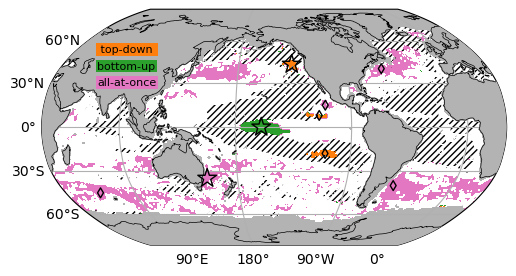

In [107]:
fig = plt.figure(figsize=(6,4))
a = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(210))
a.set_global()
a.coastlines(zorder=9,lw=0.5)
a.add_feature(cfeature.LAND, color='0.7',zorder=3)
gl = a.gridlines(draw_labels=True,xlocs=np.arange(-180,180,90))
gl.top_labels = False

a.annotate(' top-down ', (.12,.85), xycoords='axes fraction', fontsize=8, horizontalalignment='left',verticalalignment='top',zorder=99,bbox=dict(facecolor='C1',pad=1,edgecolor='none'))
a.annotate('bottom-up', (.12,.78), xycoords='axes fraction', fontsize=8, horizontalalignment='left',verticalalignment='top',zorder=99,bbox=dict(facecolor='C2',pad=1,edgecolor='none'))
a.annotate('all-at-once', (.12,.71), xycoords='axes fraction', fontsize=8, horizontalalignment='left',verticalalignment='top',zorder=99,bbox=dict(facecolor='C6',pad=1,edgecolor='none'))
a.scatter(longitude_locations,latitude_locations,marker='*',s=200,transform=ccrs.PlateCarree(),zorder=10,facecolor='none',edgecolor='k')
a.scatter(supp_longitude_locations,supp_latitude_locations,marker='d',s=25,transform=ccrs.PlateCarree(),zorder=10,facecolor='none',edgecolor='k')
a.contourf(ncvars['lon'][:],ncvars['lat'][:],subsurface_anomaly_signature-.5,levels=np.arange(5),colors=['C1','C2','C6','w'],transform=ccrs.PlateCarree())
a.contourf(ncvars['lon'][:],ncvars['lat'][:],no_sigvals,levels=[0.5,1.5],hatches=['/////'],colors=['none'],transform=ccrs.PlateCarree())
a.contourf(ncvars['lon'][:],ncvars['lat'][:],nodata,levels=[0.5,1.5],colors=['0.7','none'],transform=ccrs.PlateCarree())

plt.savefig('Figure_map_types_final.png',dpi=300)

# Calculate areas

In [70]:
weights = np.repeat(np.expand_dims(np.sin(np.linspace(0,np.pi,180)),1),360,axis=1);
weights[nodata] = 0
weights /= np.sum(weights)

Sum of all weights: 1.00


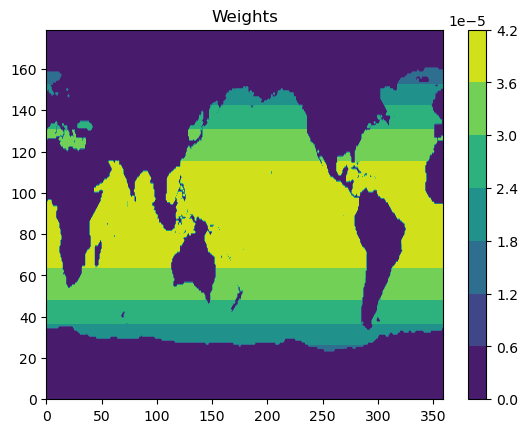

In [75]:
plt.contourf(weights)
plt.colorbar()
plt.title('Weights')
print('Sum of all weights: %.2f'%np.sum(weights))

In [104]:
print('Fraction with max corr > 0.5: %.2f'%np.sum((max_correlation>0.5)*weights))
print('Fraction of (max corr > 0.5) with lag at max corr <= 4 weeks: %.2f'%(np.sum(((max_correlation>0.5) & (max_correlation_lag<=4))*weights)/np.sum((max_correlation>0.5)*weights)))
print('Fraction of (max corr > 0.5) with lag at max corr <= 1 weeks: %.2f'%(np.sum(((max_correlation>0.5) & (max_correlation_lag<=1))*weights)/np.sum((max_correlation>0.5)*weights)))
print('Fraction with lag at max corr <= 4 weeks: %.2f'%np.sum((max_correlation_lag<=4)*weights))
print('Fraction with lag at max corr > 12 weeks: %.2f'%np.sum((max_correlation_lag>12)*weights))
print('Fraction with lag at max corr < -4 weeks: %.2f'%np.sum((max_correlation_lag<-4)*weights))
print('Fraction with lag at max corr <= 1 week: %.2f'%np.sum((max_correlation_lag<=1)*weights))
print('Fraction with lag at max corr <= 1 week AND max significant lag <= 12 weeks: %.2f'%np.sum(((max_correlation_lag<=1) & (max_significant_lag<=12))*weights))

Fraction with max corr > 0.5: 0.31
Fraction of (max corr > 0.5) with lag at max corr <= 4 weeks: 0.98
Fraction of (max corr > 0.5) with lag at max corr <= 1 weeks: 0.97
Fraction with lag at max corr <= 4 weeks: 0.68
Fraction with lag at max corr > 12 weeks: 0.02
Fraction with lag at max corr < -4 weeks: 0.01
Fraction with lag at max corr <= 1 week: 0.66
Fraction with lag at max corr <= 1 week AND max significant lag <= 12 weeks: 0.57


In [115]:
print('Fraction top-down: %.3f'%np.sum((subsurface_anomaly_signature==1)*weights))
print('Fraction bottom-up: %.3f'%np.sum((subsurface_anomaly_signature==2)*weights))
print('Fraction all-at-once: %.3f'%np.sum((subsurface_anomaly_signature==3)*weights))
print('Fraction with no significant correlation between surface and 150 db: %.3f'%np.sum((np.isnan(subsurface_anomaly_signature))*weights))

Fraction top-down: 0.010
Fraction bottom-up: 0.012
Fraction all-at-once: 0.177
Fraction with no significant correlation between surface and 150 db: 0.292


# Supplementary Figures

### Supp Figure 1: Lagged correlation plots for secondary example locations

In [76]:
supp_ocean_temperatures = np.array([data['ocean_temperature'][:,:,latind,lonind].values for latind,lonind in zip(supp_latitude_inds,supp_longitude_inds)])

In [77]:
supp_temp_detrend = np.empty(shape=supp_ocean_temperatures.shape)
for i in range(len(supp_temp_detrend)):
    print(i)
    for j in tqdm(range(len(pressure))):
        supp_temp_detrend[i,:,j] = detrend_data(data['time'].values, supp_ocean_temperatures[i,:,j], num_harmonics=6, remove_trend=True)['data']

0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 34.79it/s]


1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 35.88it/s]


2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 33.64it/s]


3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 37.10it/s]


4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 35.27it/s]


5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 34.19it/s]


In [78]:
lags = np.arange(-52*1,int(np.ceil(52*2.5))+1)
supp_lagged_corr = np.zeros(shape=(len(supp_latitude_locations),len(pressure),len(lags)))*np.nan
supp_lagged_p = np.zeros(shape=(len(supp_latitude_locations),len(pressure),len(lags)))*np.nan
supp_lagged_n = np.zeros(shape=(len(supp_latitude_locations),len(pressure),len(lags)))*np.nan

for i in range(len(supp_latitude_locations)):
    print(i,end='')
    for j in tqdm(range(len(pressure))):
        for k in range(len(lags)):
            supp_lagged_corr[i,j,k],supp_lagged_p[i,j,k],supp_lagged_n[i,j,k] = lag_corr(supp_temp_detrend[i,:,0],supp_temp_detrend[i,:,j],lags[k],return_n = True)


0

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:12<00:00,  3.50it/s]


1

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:12<00:00,  3.51it/s]


2

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:12<00:00,  3.47it/s]


3

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:12<00:00,  3.61it/s]


4

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:13<00:00,  3.22it/s]


5

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:13<00:00,  3.36it/s]


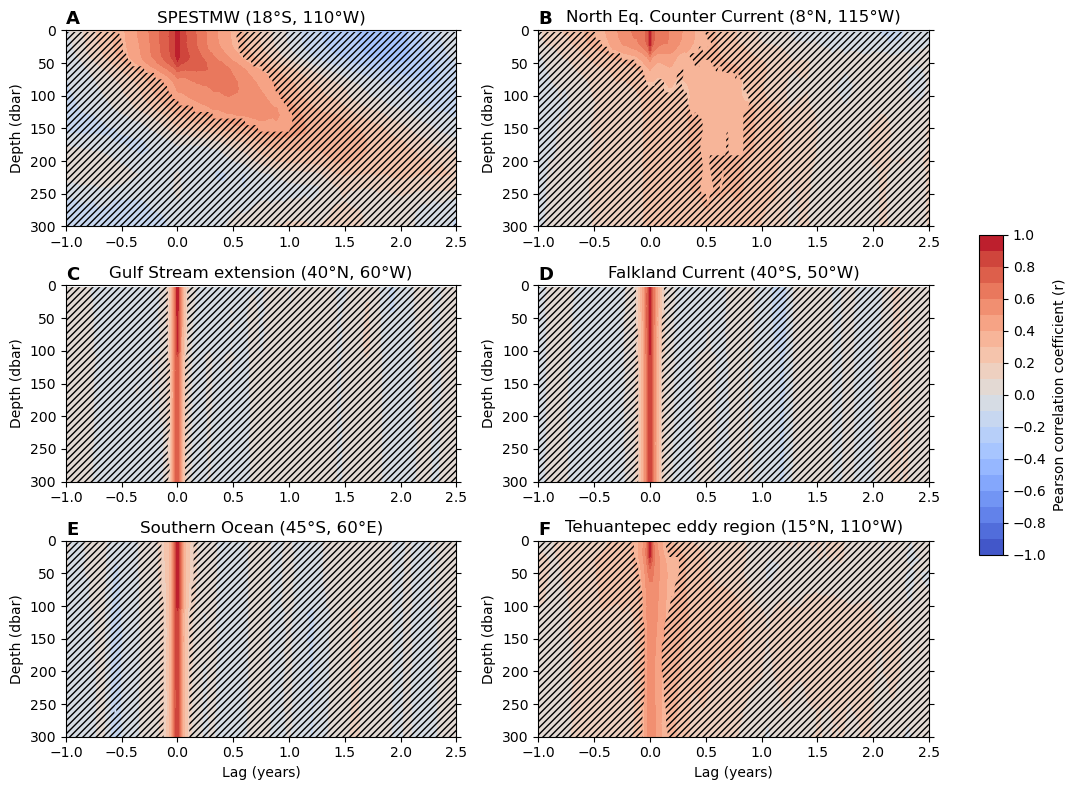

In [114]:
fig,ax = plt.subplots(3,2,figsize=(12,8))
for i in range(6):
    c = ax.ravel()[i].contourf(lags/52,pressure,supp_lagged_corr[i],cmap=plt.cm.coolwarm,levels=np.arange(-1,1.01,.1))
    ax.ravel()[i].contourf(lags/52,pressure,supp_lagged_p[i]>0.05,levels=[0.5,1.5],hatches=['/////'],colors=['none'])
for a in ax.ravel():
    a.set_ylim([300,0])
    a.set_xlim([-1,2.5])
    a.set_ylabel('Depth (dbar)')
    a.yaxis.set_ticks_position('both')
for a in ax[-1]:
    a.set_xlabel('Lag (years)')
ax.ravel()[0].set_title('SPESTMW (18°S, 110°W)')
ax.ravel()[1].set_title('North Eq. Counter Current (8°N, 115°W)')
ax.ravel()[2].set_title('Gulf Stream extension (40°N, 60°W)')
ax.ravel()[3].set_title('Falkland Current (40°S, 50°W)')
ax.ravel()[4].set_title('Southern Ocean (45°S, 60°E)')
ax.ravel()[5].set_title('Tehuantepec eddy region (15°N, 110°W)')
plt.tight_layout(rect=(0,0,0.8,1))
cax = fig.add_axes([0.82,0.3,0.02,0.4])
plt.colorbar(c,cax=cax,label='Pearson correlation coefficient (r)',ticks=np.arange(-1,1.01,.2))
for a,panel in zip(ax.ravel(),['A','B','C','D','E','F']):
    a.annotate(panel,(0.0,1.03),xycoords='axes fraction',fontweight='bold',fontsize=13)
plt.savefig('Figure_lagged_correlation_supplement_final.png',dpi=300)

### Supp Figure 2: lagged correlation plots for North Pacific and Eq. Pacific without most significant event

In [80]:
def supp_pearsonr(x,y,inds_to_use=None):
    if inds_to_use is None:
        inds_to_use = np.ones(len(x)).astype('bool')
    mx = np.mean(x[inds_to_use])
    my = np.mean(y[inds_to_use])
    dx = x[inds_to_use]-mx
    dy = y[inds_to_use]-my
    return np.sum(dx*dy)/np.sqrt(np.sum(dx**2)*np.sum(dy**2))
def supp_lag_corr(array1,array2,lag,return_n = False,nlags=200):
    T1 = 2*np.max(np.cumsum(stattools.acf(array1,nlags=nlags)))
    T2 = 2*np.max(np.cumsum(stattools.acf(array2,nlags=nlags)))
    if lag>0:
        r = supp_pearsonr(array2[lag:-1],array1[:-1-lag])
    elif lag<0:
        l = int(-1.*lag)
        r = supp_pearsonr(array1[l:-1],array2[:-1-l])
    else:
        r = supp_pearsonr(array1,array2)
    l = len(array1)-np.abs(lag)
    n = (l/T1 + l/T2)/2 - 8
    n *= np.sum(~array1.mask)/len(array1)
    dist = beta(n/2-1,n/2-1,loc=-1,scale=2)
    p = 2*dist.cdf(-abs(r))
    if return_n:
        return r,p,n
    else:
        return r,p

In [81]:
lags = np.arange(-52*1,int(np.ceil(52*2.5))+1)
lagged_corr_omit = np.zeros(shape=(2,len(pressure),len(lags)))*np.nan
lagged_p_omit = np.zeros(shape=(2,len(pressure),len(lags)))*np.nan
lagged_n_omit = np.zeros(shape=(2,len(pressure),len(lags)))*np.nan

for i in range(2):
    print(i,end='')
    for j in tqdm(range(len(pressure))):
        for k in range(len(lags)):
            if i==0:
                mask = ((yeartime>2014) & (yeartime<2018.5))
            elif i==1:
                mask = ((yeartime>2014) & (yeartime<2016))
            array1 = np.ma.array(temp_detrend[i,:,0],mask=mask)
            array2 = np.ma.array(temp_detrend[i,:,j],mask=mask)
            lagged_corr_omit[i,j,k],lagged_p_omit[i,j,k],lagged_n_omit[i,j,k] = supp_lag_corr(array1,array2,lags[k],return_n = True)
    print('')

0

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:16<00:00,  2.72it/s]



1

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:15<00:00,  2.89it/s]

In [82]:
lags = np.arange(-52*1,int(np.ceil(52*2.5))+1)
lagged_corr_noomit = np.zeros(shape=(2,len(pressure),len(lags)))*np.nan
lagged_p_noomit = np.zeros(shape=(2,len(pressure),len(lags)))*np.nan
lagged_n_noomit = np.zeros(shape=(2,len(pressure),len(lags)))*np.nan

for i in range(2):
    print(i,end='')
    for j in tqdm(range(len(pressure))):
        for k in range(len(lags)):
            array1 = np.ma.array(temp_detrend[i,:,0],mask=yeartime<0)
            array2 = np.ma.array(temp_detrend[i,:,j],mask=yeartime<0)
            lagged_corr_noomit[i,j,k],lagged_p_noomit[i,j,k],lagged_n_noomit[i,j,k] = supp_lag_corr(array1,array2,lags[k],return_n = True)
    print('')

0

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:14<00:00,  3.12it/s]



1

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:13<00:00,  3.18it/s]

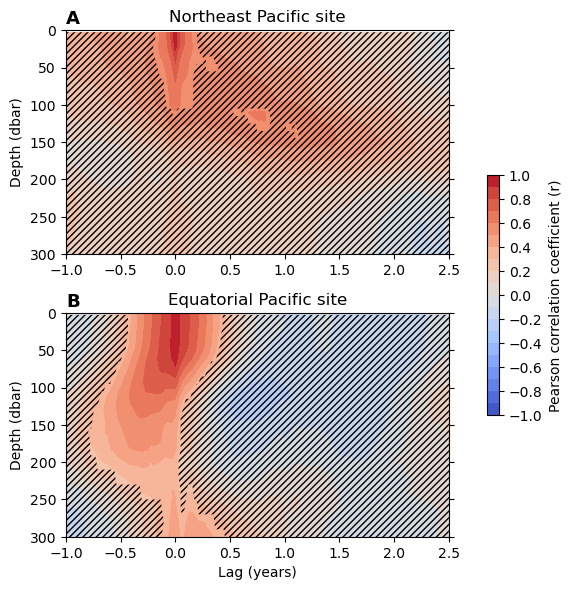

In [84]:
fig,ax = plt.subplots(2,1,figsize=(6,6))
for i in range(2):
    c = ax[i].contourf(lags/52,pressure,lagged_corr_omit[i],cmap=plt.cm.coolwarm,levels=np.arange(-1,1.01,.1))
    ax[i].contourf(lags/52,pressure,lagged_p_omit[i]>0.05,levels=[0.5,1.5],hatches=['/////'],colors=['none'])
    ax[i].set_ylim([300,0])
    ax[i].set_xlim([-1,2.5])
    ax[i].set_ylabel('Depth (dbar)')
    ax[i].yaxis.set_ticks_position('both')
ax[1].set_xlabel('Lag (years)')
ax[0].set_title('Northeast Pacific site')
ax[1].set_title('Equatorial Pacific site')
plt.tight_layout(rect=(0,0,0.8,1))
cax = fig.add_axes([0.82,0.3,0.02,0.4])
plt.colorbar(c,cax=cax,label='Pearson correlation coefficient (r)',ticks=np.arange(-1,1.01,.2))
for a,panel in zip(ax,['A','B','C']):
    a.annotate(panel,(0.0,1.03),xycoords='axes fraction',fontweight='bold',fontsize=13)
plt.savefig('Figure_lagged_correlation_omit_supplement_final.png',dpi=300)

This should be the same as the figure in the main part of the paper (no omissions)


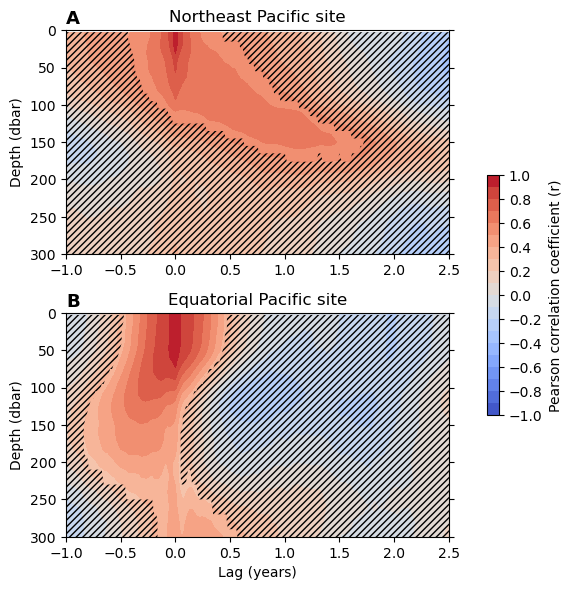

In [90]:
fig,ax = plt.subplots(2,1,figsize=(6,6))
for i in range(2):
    c = ax[i].contourf(lags/52,pressure,lagged_corr_noomit[i],cmap=plt.cm.coolwarm,levels=np.arange(-1,1.01,.1))
    ax[i].contourf(lags/52,pressure,lagged_p_noomit[i]>0.05,levels=[0.5,1.5],hatches=['/////'],colors=['none'])
    ax[i].set_ylim([300,0])
    ax[i].set_xlim([-1,2.5])
    ax[i].set_ylabel('Depth (dbar)')
    ax[i].yaxis.set_ticks_position('both')
ax[1].set_xlabel('Lag (years)')
ax[0].set_title('Northeast Pacific site')
ax[1].set_title('Equatorial Pacific site')
plt.tight_layout(rect=(0,0,0.8,1))
cax = fig.add_axes([0.82,0.3,0.02,0.4])
plt.colorbar(c,cax=cax,label='Pearson correlation coefficient (r)',ticks=np.arange(-1,1.01,.2))
for a,panel in zip(ax,['A','B','C']):
    a.annotate(panel,(0.0,1.03),xycoords='axes fraction',fontweight='bold',fontsize=13)
print('This should be the same as the figure in the main part of the paper (no omissions)')